In [1]:
library (tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
zillow_url1 <- paste0("http://files.zillowstatic.com/research/public/City/",
                    "City_MedianRentalPricePerSqft_AllHomes.csv")
zillow_url2 <- paste0("http://files.zillowstatic.com/research/public/City/",
                      "City_ZriPerSqft_AllHomes.csv")
price_per_sqft <- read_csv(zillow_url1)
value_per_sqft <- read_csv(zillow_url2)
price_per_sqft <- price_per_sqft %>%
    select(-Metro) %>%
    gather(`2010-01`:`2018-08`, key = "date", value = "price") 
value_per_sqft <- value_per_sqft %>%
    select(RegionID:CountyName, `2011-01`:`2018-08`) %>%
    gather(`2011-01`:`2018-08`, key = "date", value = "value") 
home_per_sqft <- price_per_sqft %>%
    inner_join(value_per_sqft)
home_per_sqft <- home_per_sqft %>%
    mutate(date = paste0(date, "-01"),
           date = as.Date(date))
top10_States <- home_per_sqft %>%
    filter(date >= as.Date("2018-01-01")) %>%
    filter(State != "HI", State != "DC") %>%
    group_by(State) %>%
    summarise(price = mean(price, na.rm = TRUE)) %>%
    top_n(10)
home_per_sqft <- home_per_sqft %>%
    filter(State %in% top10_States$State)
locale <- Sys.setlocale(category = "LC_ALL", locale = "C")

Parsed with column specification:
cols(
  .default = col_double(),
  RegionName = col_character(),
  State = col_character(),
  Metro = col_character(),
  CountyName = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  .default = col_double(),
  RegionName = col_character(),
  State = col_character(),
  Metro = col_character(),
  CountyName = col_character()
)

See spec(...) for full column specifications.

Joining, by = c("RegionName", "State", "CountyName", "date")

Selecting by price



In [3]:
head(home_per_sqft)

RegionName,State,CountyName,SizeRank,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,⋯,2019-08,2019-09,2019-10,2019-11,2019-12,date,price,RegionID,Metro,value
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<chr>,<dbl>
New York,NY,Queens County,1,3.809524,3.747917,3.714286,3.666667,3.619691,3.750000,⋯,3.953488,3.931801,3.908907,3.906058,3.988734,2011-01-01,NA,6181,New York-Newark-Jersey City,1.454
Los Angeles,CA,Los Angeles County,2,2.681818,2.678571,2.693154,2.670527,2.680369,2.711187,⋯,2.772794,2.786786,2.777778,2.763934,2.770099,2011-01-01,1.838462,12447,Los Angeles-Long Beach-Anaheim,1.580
San Diego,CA,San Diego County,9,2.272727,2.260389,2.277919,2.313084,2.330211,2.365591,⋯,2.349128,2.343521,2.346688,2.375746,2.371473,2011-01-01,1.738698,54296,San Diego-Carlsbad,1.490
San Jose,CA,Santa Clara County,12,2.426138,2.406790,2.379481,2.383889,2.412037,2.465972,⋯,2.423313,2.404723,2.384046,2.390671,2.408854,2011-01-01,1.566416,33839,San Jose-Sunnyvale-Santa Clara,1.540
San Francisco,CA,San Francisco County,15,4.146341,4.071429,4.102640,4.155598,4.223402,4.215087,⋯,4.303954,4.347769,4.312354,4.251007,4.255319,2011-01-01,2.594340,20330,San Francisco-Oakland-Hayward,2.534
Denver,CO,Denver County,24,1.887630,1.859838,1.842546,1.849918,1.856944,1.878371,⋯,1.974444,1.965594,1.930954,1.911296,1.932042,2011-01-01,1.269036,11093,Denver-Aurora-Lakewood,1.100


In [4]:
home_per_sqft %>%
    filter(is.na(value)) %>%
    summarise(count = n())

count
<int>
90


In [5]:
home_per_sqft %>% 
mutate(profit = price - value) %>%
filter(!is.na(profit)) %>%
group_by(State) %>%
summarise(median_profit = median(profit)) %>%
arrange(desc(median_profit))

State,median_profit
<chr>,<dbl>
ME,0.39621724
MA,0.20182646
RI,0.12390207
NJ,0.10909648
NY,0.09180827
CO,0.07552124
NH,0.06197436
CT,0.05417602
MD,0.03488889


Or

In [6]:
home_per_sqft %>% 
mutate(profit = price - value) %>%
group_by(State) %>%
summarise(median_profit = median(profit, na.rm = T)) %>%
top_n(median_profit, n=2)

State,median_profit
<chr>,<dbl>
MA,0.2018265
ME,0.3962172


Warning message:
"Removed 174 rows containing non-finite values (stat_smooth)."


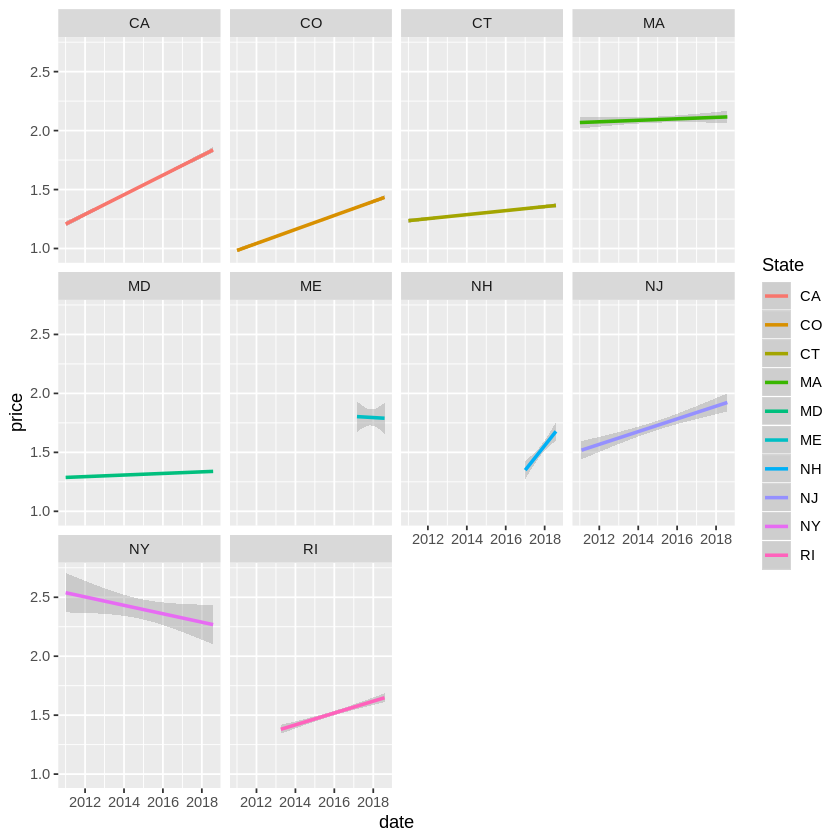

In [7]:
df <- home_per_sqft %>%
    group_by(State, date) %>%
    summarise(price = mean(price, na.rm = TRUE))
ggplot(data = df, aes(x = date, y = price, color = State)) +
    geom_smooth(method = 'lm') +
  facet_wrap(~State)

In [8]:
home_per_sqft %>% 
filter(!is.na(price) & price > 1.5) %>% 
group_by(State) %>%
summarise(count = n()) %>%
top_n(count, n=3)

State,count
<chr>,<int>
CA,6786
MA,871
NJ,597
